# Recommendation Systems

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget

## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


## Data Preprocessing

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    ###########         end         ###########
    return matrix

In [0]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

## Baseline Recommendation System

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
          # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
            # select the row for user
            # what's the shape of userVector
            userVector = train_matrix[user, :]
            
            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))
            ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
          numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
          numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
          if numOfUsersRated == 0:
            itemPopularity[item] = 0
          else:
            itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
          # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
            predictionMatrix[user, item] = itemPopularity[item]
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
              print ("calculated %d users" % (user,))
              ###########         end         ##########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).tail()

100000it [01:40, 995.34it/s]


,userID,itemID,rating,timestamp,popularity
99995,880,476,3,880175444,0.0
99996,716,204,5,879795543,0.0
99997,276,1090,1,874795795,0.0
99998,13,225,2,882399156,0.0
99999,12,203,3,879959583,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:40, 997.31it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Similarity Based Recommendation System

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ##########
        similarity_matrix = 1/(1+pairwise_distances(matrix, metric='euclidean'))
        ###########         end         ###########    
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1/(1+pairwise_distances(matrix, metric='correlation'))
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
          # Initialize the predicted rating matrix with zeros
          temp_matrix = np.zeros(train_matrix.shape)
          temp_matrix[train_matrix.nonzero()] = 1
          uu_similarity = self.method(train_matrix)
          normalizer = np.matmul(uu_similarity, temp_matrix)
          #print(normalizer)
          normalizer[normalizer == 0] = 1e-5
          #what's the dimension of np.matmul(uu_similarity, trainSet)
          predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
          #predictionMatrix[temp_matrix.nonzero()] = 0
          #Cold start
          # if no one has rated this item before, use user average  
          useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
          columns = np.sum(predictionMatrix, axis=0)
          #print(columns.shape)
          predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
          self.__model=predictionMatrix
            
        elif self.base == 'item':
           # Initialize the predicted rating matrix with zeros
          train_matrix=train_matrix.transpose()
          temp_matrix = np.zeros(train_matrix.shape)
          temp_matrix[train_matrix.nonzero()] = 1
          ii_similarity = self.method(train_matrix)
          normalizer = np.matmul(ii_similarity, temp_matrix)
          #print(normalizer)
          normalizer[normalizer == 0] = 1e-5
          #what's the dimension of np.matmul(ii_similarity, trainSet)
          predictionMatrix = np.matmul(ii_similarity, train_matrix)/normalizer
          #predictionMatrix[temp_matrix.nonzero()] = 0
          #Cold start
          # if no one has rated this item before, use user average  
          useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
          columns = np.sum(predictionMatrix, axis=0)
          #print(columns.shape)
          predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
          self.__model=predictionMatrix.transpose()
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
# Examples of how to call similarity functions.
I = np.eye(5)
SimBasedRecSys.cosine(I)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [0]:
I

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356, 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356, 0.41421356, 0.41421356],
       [0.41421356, 0.41421356, 1.        , 0.41421356, 0.41421356],
       [0.41421356, 0.41421356, 0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 0.41421356, 0.41421356, 1.        ]])

Cosine similarity outperforms Euclidean similarity, because here there is no magnitude based similarity to be identified. Euclidean works well if recommendation vaires based on the number of ratings and also if data is not sparse.



In [0]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.44444444, 0.44444444, 0.44444444, 0.44444444],
       [0.44444444, 1.        , 0.44444444, 0.44444444, 0.44444444],
       [0.44444444, 0.44444444, 1.        , 0.44444444, 0.44444444],
       [0.44444444, 0.44444444, 0.44444444, 1.        , 0.44444444],
       [0.44444444, 0.44444444, 0.44444444, 0.44444444, 1.        ]])

In the function somethingelse(), <b>Pearson Correlation</b> has been used as a similarity metric.
It is a good metric as the ratings are subjective and can have user bias.
Predictions are computed as weighted average of deviations from neighbor’s mean and adding it to active user’s mean rating. Deviations are used to adjust for the user associated biases. User biases occur as certain users may tend to always give high or low ratings to all items.

https://towardsdatascience.com/collaborative-filtering-based-recommendation-systems-exemplified-ecbffe1c20b1

In [0]:
user_euclidean_recsys=SimBasedRecSys('user','euclidean')

In [0]:
user_euclidean_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_euclidean_recsys.getModel()

array([[4.01198263, 3.12418862, 3.42705668, ..., 2.        , 3.        ,
        3.        ],
       [3.86253864, 3.16950956, 2.99792308, ..., 2.        , 3.        ,
        3.        ],
       [3.84909355, 3.16385928, 3.01514304, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.93682232, 3.16551579, 3.02181349, ..., 2.        , 3.        ,
        3.        ],
       [3.86185901, 3.17727086, 3.00916338, ..., 2.        , 3.        ,
        3.        ],
       [3.86877521, 3.72816665, 3.02758764, ..., 2.        , 3.        ,
        3.        ]])

In [0]:
user_euclidean_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:41, 988.69it/s]


,userID,itemID,rating,timestamp,user-euclidean
0,196,242,3,881250949,3.769730
1,186,302,3,891717742,3.995608
2,22,377,1,878887116,1.207796
3,244,51,2,880606923,2.798725
4,166,346,1,886397596,3.024971


In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:44, 956.84it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [0]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:45, 949.95it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


## Cross Validation with metrics

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return round(sqrt(mean_squared_error(data[pred], data[true])),4)
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision 
            countPrecisions += 1

        # Return average P@k
        return round(float(sumPrecisions)/countPrecisions,4)
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return round(float(sumRecalls)/countRecalls,4)
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            index = ['Fold Values', 'Mean value', 'CI low', 'CI high']
            
        results = pd.DataFrame(scores,index=index)
    
        return results
            

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,item_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# RMSE in this example
cv_rmse = CrossValidation('RMSE')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_rmse.run(algorithm_instances, num_users, num_items,k=5)


Processing algorithm user-cosine


20000it [00:13, 1505.78it/s]
20000it [00:13, 1471.71it/s]
20000it [00:13, 1459.37it/s]
20000it [00:13, 1494.97it/s]
20000it [00:13, 1490.74it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1478.74it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1463.59it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1457.02it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1461.45it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:14, 1405.37it/s]


,user-cosine,item-cosine
Fold Values,"[1.0264, 1.0214, 1.0133, 1.0094, 1.0162]","[1.0378, 1.0207, 1.0102, 1.0137, 1.0181]"
Mean value,1.01734,1.0201
CI low,1.00903,1.00683
CI high,1.02565,1.03337


It is observed from the Cross Validation and RMSE values, User-User cosine similarity performs better than the Item-Item cosine similarity.
This could be because of the sparsity in the item data,leading to higher RMSE. 
Average number of ratings per user (106) are more than the average number of ratings per item (59.45). From the average number of ratings of both users and items, it can be concluded that Item data is more sparse leading to high RMSE.


## Probablistic Matrix Factorization

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = sqrt(0.1)*np.random.randn(num_item, self.num_feat)+0  # item M x D 
        self.w_User = sqrt(0.1)*np.random.randn(num_user, self.num_feat)+0  # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = np.sum(self.w_Item[batch_ItemID]*self.w_User[batch_UserID], axis=1) #size (batch_size, ) #size (batch_size, )
            
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_Item[train_item_idx]*self.w_User[train_user_idx], axis=1) # size(pairs_train, ) # size(pairs_train, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = np.sum(self.w_Item[val_item_idx]*self.w_User[val_user_idx], axis=1) #size(pairs_val, )
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
        plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
        plt.title('The MovieLens Dataset Learning Curve')
        plt.xlabel('Number of Epochs')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid()
        plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 17, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

Optimal number for <b> maxepoch is :17 </b>. This helps to avoid overfitting.

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

In [0]:
algorithm_instances_1 = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,item_cosine_recsys,pmf]

In [0]:
CV_patk = CrossValidation('P@K')

In [0]:
CV_patk.run(algorithm_instances_1, num_users, num_items,k=5)

Processing algorithm popularity
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1518.60it/s]


calculated 0 users
calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1482.44it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1495.23it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1477.53it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1493.53it/s]


Processing algorithm useraverage


20000it [00:13, 1484.95it/s]
20000it [00:13, 1487.22it/s]
20000it [00:13, 1497.82it/s]
20000it [00:13, 1484.97it/s]
20000it [00:13, 1509.45it/s]


Processing algorithm user-cosine


20000it [00:13, 1510.44it/s]
20000it [00:13, 1498.57it/s]
20000it [00:13, 1501.32it/s]
20000it [00:13, 1498.89it/s]
20000it [00:13, 1489.39it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1474.71it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1498.12it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1484.81it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1481.50it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1509.11it/s]


Processing algorithm PMF


20000it [00:21, 918.73it/s]
20000it [00:21, 909.24it/s]
20000it [00:22, 900.77it/s]
20000it [00:22, 905.90it/s]
20000it [00:21, 913.38it/s]


,popularity,useraverage,user-cosine,item-cosine,PMF
Fold Values,"[0.3692, 0.4965, 0.6153, 0.6426, 0.6293]","[0.306, 0.4305, 0.5321, 0.5521, 0.5474]","[0.3718, 0.5039, 0.6216, 0.6484, 0.6335]","[0.3432, 0.4836, 0.6021, 0.6248, 0.6074]","[0.3642, 0.4944, 0.614, 0.6348, 0.6225]"
Mean value,0.55058,0.47362,0.55584,0.53222,0.54598
CI low,0.405411,0.341953,0.409593,0.38374,0.401611
CI high,0.695749,0.605287,0.702087,0.6807,0.690349


In [0]:
CV_rmse = CrossValidation('RMSE')

In [0]:
CV_rmse.run(algorithm_instances_1, num_users, num_items,k=5)

Processing algorithm popularity
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1454.40it/s]


calculated 0 users
calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1461.44it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1488.84it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1459.05it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1442.90it/s]


Processing algorithm useraverage


20000it [00:13, 1510.17it/s]
20000it [00:13, 1504.42it/s]
20000it [00:13, 1499.79it/s]
20000it [00:13, 1501.81it/s]
20000it [00:13, 1483.25it/s]


Processing algorithm user-cosine


20000it [00:13, 1464.99it/s]
20000it [00:13, 1467.42it/s]
20000it [00:13, 1472.04it/s]
20000it [00:13, 1534.81it/s]
20000it [00:13, 1491.25it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1525.18it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1477.88it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1482.69it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1509.70it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1466.97it/s]


Processing algorithm PMF


20000it [00:22, 903.09it/s]
20000it [00:21, 916.05it/s]
20000it [00:22, 908.19it/s]
20000it [00:21, 909.26it/s]
20000it [00:21, 910.25it/s]


,popularity,useraverage,user-cosine,item-cosine,PMF
Fold Values,"[3.1779, 3.175, 3.1475, 3.1462, 3.1488]","[1.063, 1.0467, 1.0329, 1.0367, 1.0393]","[1.0264, 1.0214, 1.0133, 1.0094, 1.0162]","[1.0378, 1.0207, 1.0102, 1.0137, 1.0181]","[0.9879, 0.9692, 0.9524, 0.9589, 0.9546]"
Mean value,3.15908,1.04372,1.01734,1.0201,0.9646
CI low,3.13932,1.02894,1.00903,1.00683,0.946549
CI high,3.17884,1.0585,1.02565,1.03337,0.982651


In [0]:
CV_ratk = CrossValidation('R@K')

In [0]:
CV_ratk.run(algorithm_instances_1, num_users, num_items,k=5)

Processing algorithm popularity
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1480.89it/s]


calculated 0 users
calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1483.13it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1480.50it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1489.21it/s]


calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:13, 1515.25it/s]


Processing algorithm useraverage


20000it [00:13, 1497.03it/s]
20000it [00:13, 1504.25it/s]
20000it [00:13, 1499.37it/s]
20000it [00:13, 1505.02it/s]
20000it [00:13, 1507.82it/s]


Processing algorithm user-cosine


20000it [00:13, 1487.64it/s]
20000it [00:13, 1477.57it/s]
20000it [00:13, 1463.24it/s]
20000it [00:13, 1502.31it/s]
20000it [00:13, 1463.47it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1468.35it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1469.90it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1486.64it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1464.66it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide
20000it [00:13, 1491.75it/s]


Processing algorithm PMF


20000it [00:21, 910.76it/s]
20000it [00:21, 924.12it/s]
20000it [00:22, 906.58it/s]
20000it [00:22, 901.24it/s]
20000it [00:21, 921.62it/s]


,popularity,useraverage,user-cosine,item-cosine,PMF
Fold Values,"[0.3467, 0.4274, 0.5269, 0.5519, 0.5675]","[0.3051, 0.3955, 0.4803, 0.5046, 0.5211]","[0.3478, 0.4314, 0.5294, 0.5554, 0.5674]","[0.3278, 0.4238, 0.5191, 0.5449, 0.5593]","[0.3328, 0.4209, 0.5207, 0.5385, 0.5656]"
Mean value,0.48408,0.44132,0.48628,0.47498,0.4757
CI low,0.367143,0.329322,0.369461,0.353597,0.355518
CI high,0.601017,0.553318,0.603099,0.596363,0.595882


## Analysis

Baselines used here are - Popularity based and User average based recommender systems. 

<b>Popularity based </b>can be well evaluated with P@K and R@K. This is because popularity based recommender system uses top rated items per user. As our ranking metrics use top rated or top ranked items, they perform well for this algorithm.

<b>User average based</b> can be evaluated by using RMSE, as both function on the same lines i.e., using average of the ratings and recommending.

<b>RMSE - PMF -</b> Considering all ratings and assigning weights based on the probability values.

<b>P@K - User_Cosine -</b> Number of user similarity based on cosine helps to group relevant items together. 

<b>R@K - User_Cosine -</b> Number of user similarity based on cosine helps to group relevant items together. 

Good performance on RMSE doesnot directly imply good performance on ranking metrics. Ranking metrics is used to evaluate a golden ranked list (typically human judged) against your output ranked list. The more is the correlation between the two ranked lists, i.e. the more similar are the ranks of the relevant items in the two lists, the closer is the value of metrics to 1.

RMSE (Root Mean Squared Error) is typically used to evaluate regression problems where the output (a predicted scalar value) is compared with the true scalar value output for a given data point.

So, if you are simply recommending a score (such as recommending a movie rating), then use RMSE. Whereas, if you are recommending a list of items (such as a list of related movies), then use ranking metrics (viz. P@K and R@K)



## Evaluation



Jaws (Action and Horror)

Mission:Impossible (Action, Adventure and Mystery)

Twilight (Crime and Drama)

In [0]:
  def userTopK(moviesDataset,ratings, num_users, num_items,movieTitle,k):
    item_matrix=dataPreprocessor(rating_df, num_users, num_items)
    item_matrix=item_matrix.transpose()
    icr = SimBasedRecSys.cosine(item_matrix)
    movieID=moviesDF.loc[moviesDF['movieTitle']==movieTitle]['movieID'].values[0]
    itemVector = icr[movieID-1,:]
    topK = nlargest(k+1, range(len(itemVector)), itemVector.take)
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
    return namesTopK[1:]

In [0]:
userTopK(moviesDF,rating_df, num_users, num_items,'Jaws (1975)',5)

['Silence of the Lambs, The (1991)',
 'Raiders of the Lost Ark (1981)',
 'Alien (1979)',
 'Fugitive, The (1993)',
 'Pulp Fiction (1994)']

In [0]:
userTopK(moviesDF,rating_df, num_users, num_items,'Mission: Impossible (1996)',5)

['Independence Day (ID4) (1996)',
 'Rock, The (1996)',
 'Twister (1996)',
 'Eraser (1996)',
 'Broken Arrow (1996)']

In [0]:
userTopK(moviesDF,rating_df, num_users, num_items,'Twilight (1998)',5)

['Love and Death on Long Island (1997)',
 'Nil By Mouth (1997)',
 'Primary Colors (1998)',
 'U.S. Marshalls (1998)',
 'Great Day in Harlem, A (1994)']

From the analysis, the similarities obtained are very satisfactory. Based on the genre chosen for each movie, the recommended movies seem to be in either one or both of the genre. We can also find that the movies so recommended also are released closer to the release date of the chosen movie.
Some suggestions also have the same user ratings.

## Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d59259fd0>]],
      dtype=object)

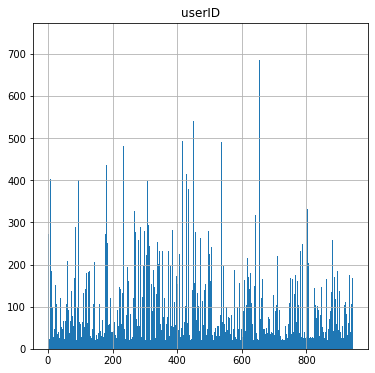

In [0]:
rating_df.hist(column="userID",bins=943,figsize=(6,6))



In [0]:
count= pd.DataFrame(rating_df.groupby('userID')['rating'].count()).reset_index()
count

,userID,rating
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175
...,...,...
938,939,49
939,940,107
940,941,22
941,942,79


In [0]:
count.isna().sum()

userID    0
rating    0
dtype: int64

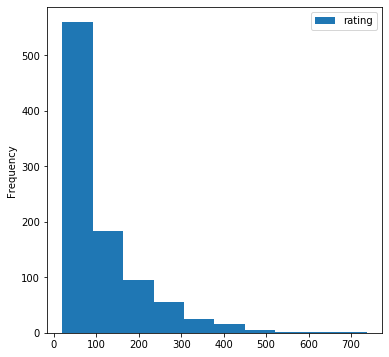

In [0]:
count.plot( x='userID', y='rating', kind='hist',figsize=(6,6))


In [0]:
count.describe()

,userID,rating
count,943.000000,943.000000
mean,472.000000,106.044539
std,272.364951,100.931743
min,1.000000,20.000000
25%,236.500000,33.000000
50%,472.000000,65.000000
75%,707.500000,148.000000
max,943.000000,737.000000


In [0]:
datasetsFileNames = [('u1.base', 'u1.test'),
                     ('u2.base', 'u2.test'),
                     ('u3.base', 'u3.test'),
                     ('u4.base', 'u4.test'),
                     ('u5.base', 'u5.test')]
fields = ['userID', 'itemID', 'rating', 'timestamp']


## Threshold Analysis

In [1]:
uurmseList1 = []
uurmseList2 = []

iirmseList1=[]
iirmseList2=[]

for trainFileName, testFileName in datasetsFileNames:
  trainFileNameH=rating_df[rating_df.groupby('userID')['rating'].transform('count')>65]
  trainFileNameL=rating_df[rating_df.groupby('userID')['rating'].transform('count')<=65]
  L=list(trainFileNameL.userID.values)
  H=list(trainFileNameH.userID.values)
  testFileNameh=rating_df[rating_df.groupby('userID')['rating'].transform('count')>65]
  testFileNamel=rating_df[rating_df.groupby('userID')['rating'].transform('count')<=65]
  l=list(testFileNamel.userID.values)
  h=list(testFileNameh.userID.values)
  curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
  curTrainDFH=curTrainDF[curTrainDF.userID.isin(H)]
  curTrainDFL=curTrainDF[curTrainDF.userID.isin(L)]
  curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
  curTestDFh=curTestDF[curTestDF.userID.isin(h)]
  curTestDFl=curTestDF[curTestDF.userID.isin(l)]
  
  #prediction with uusimilarity
  user_cosine_recsys.reset()
  user_cosine_recsys.predict_all(curTrainDFH,num_users,num_items)
  test_df1=user_cosine_recsys.evaluate_test(curTestDFh)
  user_cosine_recsys.reset()
  user_cosine_recsys.predict_all(curTrainDFL,num_users,num_items)
  test_df2=user_cosine_recsys.evaluate_test(curTestDFl)
  uusimRMSE1 = CrossValidation.rmse(test_df1,5,num_users, num_items, user_cosine_recsys.getPredColName())
  print(uusimRMSE1)
  uurmseList1.append(uusimRMSE1)
  uusimRMSE2 = CrossValidation.rmse(test_df2,5,num_users, num_items, user_cosine_recsys.getPredColName())
  print(uusimRMSE2)
  uurmseList2.append(uusimRMSE2)
  
  #prediction with iisimilarity
  item_cosine_recsys.reset()
  item_cosine_recsys.predict_all(curTrainDFH,num_users,num_items)
  test_df1=item_cosine_recsys.evaluate_test(curTestDFh)
  item_cosine_recsys.reset()
  item_cosine_recsys.predict_all(curTrainDFL,num_users,num_items)
  test_df2=item_cosine_recsys.evaluate_test(curTestDFl)
  iisimRMSE1 = CrossValidation.rmse(test_df1,5,num_users, num_items, item_cosine_recsys.getPredColName())
  print(iisimRMSE1)
  iirmseList1.append(iisimRMSE1)
  iisimRMSE2 = CrossValidation.rmse(test_df2,5,num_users, num_items, item_cosine_recsys.getPredColName())
  print(iisimRMSE2)
  iirmseList2.append(iisimRMSE2)


NameError: ignored

In [2]:
L=[]
ind=['UU_above τ','UU_below τ','II_above τ','II_below τ']
columns=['u1.test','u2.test','u3.test','u4.test','u5.test']
L.append(uurmseList1)
L.append(uurmseList2)
L.append(iirmseList1)
L.append(iirmseList2)
L_df=pd.DataFrame(L,index=ind,columns=columns)
L_df

NameError: ignored

From the Histogram and from the statistical analysis of data,<b> τ is set 65.</b>
As the histogram is skewed, median would be the right measure to differentiate the users with few ratings and those with a moderate to large
number of ratings.




After splitting the data based on the <b>τ</b> value, RMSE for UU_similarity above τ are lower than the RMSE for UU_similarity below τ. That is because of the number of ratings provided. Model can predict well for the users with high number of ratings than the threshold. 
It is the same case with II_similarity. RMSE for II_similarity above τ are lower than the RMSE for II_similarity below τ.

As the number of ratings are lower than threshold, prediction becomes difficult. That is the reason of high RMSE values for both UU_similarity below τ and II_similarity below τ.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)